## Website 
https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
## Source 
Luis Candanedo, luismiguel.candanedoibarra '@' umons.ac.be, University of Mons (UMONS). 

## Data Set Information:

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters). 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
energy = pd.read_csv('energydata_complete.csv')
# info
print("\ninfo \n",energy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [3]:
# Need to convert time stamp (date) to number of seconds to midnight and store it in dataframe

def timeConvert(ds):
    import datetime
    date_time = datetime.datetime.strptime(ds, "%H:%M:%S")
    a_timedelta = date_time - datetime.datetime(1900, 1, 1)
    seconds = a_timedelta.total_seconds()
    return seconds

time = [t.split(None,1)[1] for t in energy['date']]
24*timeConvert("1:00:00")
timeConvert("23:00:00")
NSM = [timeConvert(t) for t in time]
energy['NSM'] = NSM

In [4]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [5]:
columns = [col for col in energy.columns if col not in ('date','lights','Appliances')]
X = energy[columns]
y = energy[['lights','Appliances']]

# feature selection
rfe_selector = RFE(estimator=Ridge(),n_features_to_select=None)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
X = X.loc[:,rfe_support]
print("Selected features = ",X.columns.tolist())

# Normalize data
std = StandardScaler()
std.fit(X)
X = std.transform(X)

# Generate polynomial features
Xtmp = X.copy()
for d in (1,2,3):
    print("\nDegree = %g"%d)
    pf = PolynomialFeatures(degree=d)
    pf.fit(X)
    Xpoly = pf.transform(X)

    # split test set
    Xtrain, Xtest, ytrain,ytest = train_test_split(Xpoly,y)

    # train model using Linear Regression with build in regularization
    model = RidgeCV(alphas=[0.1,0.5,1,5,10])
    model.fit(Xtrain,ytrain)

    # prediction training set and test set 
    ptrain = model.predict(Xtrain)
    ptest = model.predict(Xtest)

    err_train = metrics.mean_squared_error(ytrain,ptrain)
    print("-> RMSE of training set = %g with score = %g"%(err_train**0.5,model.score(Xtrain,ytrain)))

    err_test = metrics.mean_squared_error(ytest,ptest)
    print("-> RMSE = %g of test set with score = %g"%(err_test**0.5,model.score(Xtest,ytest)))

Selected features =  ['RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T6', 'T8', 'RH_8', 'T9', 'T_out', 'Windspeed']

Degree = 1
-> RMSE of training set = 67.624 with score = 0.168809
-> RMSE = 66.4029 of test set with score = 0.181157

Degree = 2
-> RMSE of training set = 64.0836 with score = 0.264584
-> RMSE = 63.6058 of test set with score = 0.255576

Degree = 3
-> RMSE of training set = 57.0273 with score = 0.404708
-> RMSE = 62.6404 of test set with score = 0.356416


n = 100
n = 500
n = 1000
n = 1500
n = 2000
n = 2500
1500


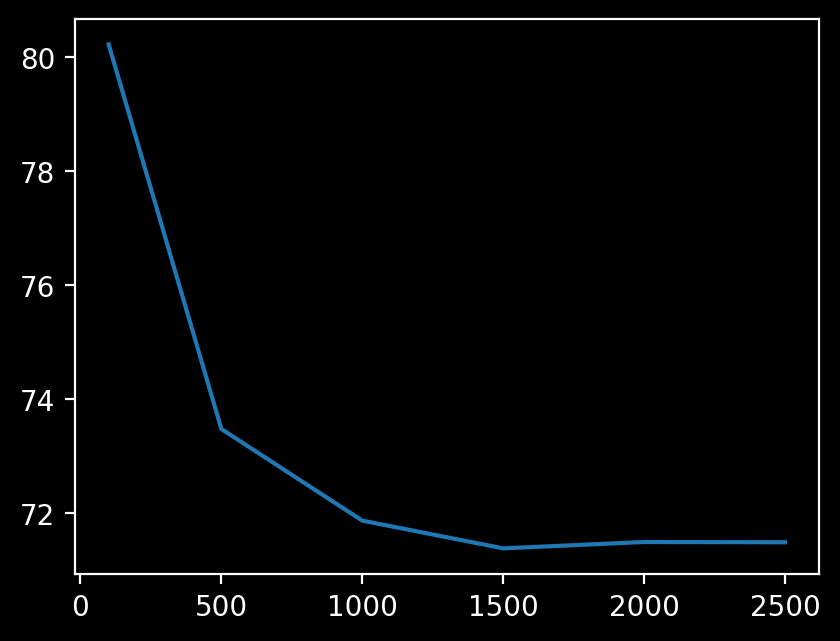

-> RMSE = 12.3847 of training set with score = 0.985691
-> RMSE = 68.2878 of test set with score = 0.509214


In [8]:
def cross_validate(X,y,Xcv,ycv,n,d=5):
    print('n = %g'%n)
    # train model using GradientBoosting Regression
    model = GradientBoostingRegressor(n_estimators=n,max_depth=d)
    model.fit(X,y)
    # predictions  
    ptest = model.predict(Xcv)
    return metrics.mean_squared_error(ycv,ptest)**0.5

columns = [col for col in energy.columns if col not in ('date','Appliances')]
X = energy[columns]
y = energy['Appliances']

# Normalize data
std = StandardScaler()
std.fit(X)
X = std.transform(X)

# run cross validation to get best value for n_estimators in GradientBoostingRegressor
# split data into 60% training, 20% cross validate, and 20% test
n_estimators = [100,500,1000,1500,2000,2500]
Xtrain,Xcv,ytrain,ycv = train_test_split(X,y,test_size=0.2)
Xtrain,Xtest,ytrain,ytest = train_test_split(Xtrain,ytrain,test_size=len(ycv)/(1.0*len(ytrain)))
cv_RMS = [cross_validate(Xtrain,ytrain,Xcv,ycv,n,d=5) for n in n_estimators]
idx = np.argmin(cv_RMS)
n = n_estimators[idx]
print(n)
plt.plot(n_estimators,cv_RMS)
plt.show()

# train model using GradientBoosting Regression
model = GradientBoostingRegressor(n_estimators=n,max_depth=5)
model.fit(Xtrain,ytrain)

# prediction training set and test set 
ptrain = model.predict(Xtrain)
ptest = model.predict(Xtest)

err_train = metrics.mean_squared_error(ytrain,ptrain)
print("-> RMSE = %g of training set with score = %g"%(err_train**0.5,model.score(Xtrain,ytrain)))

err_test = metrics.mean_squared_error(ytest,ptest)
print("-> RMSE = %g of test set with score = %g"%(err_test**0.5,model.score(Xtest,ytest)))

In [9]:
print(cv_RMS)

[80.22534423380851, 73.47119323795623, 71.86178852908269, 71.37474115260622, 71.48621058300121, 71.48156408432706]


In [10]:
ntrain = len(ytrain)
ntest = len(ytest)
ncv = len(ycv)
ntot = len(y)
print(ntrain + ntest + ncv,ntot)
print("train percentage = ",ntrain/(1.0*ntot))
print("test percentage = ",ntest/(1.0*ntot))
print("cross validation percentage = ",ncv/(1.0*ntot))

19735 19735
train percentage =  0.6
test percentage =  0.2
cross validation percentage =  0.2
